In [ ]:
!pip install pm4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=a976cec26a9aabe091a1f89db8ae38c85c36de6c1d96cb55655e78c63dfcfc93
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
!pip install markov_clustering

In [ ]:
import pm4py
import numpy as np
import markov_clustering as mc
import math

In [ ]:
event_log = pm4py.read_xes('DomesticDeclarations.xes')
df = pm4py.convert_to_dataframe(event_log)

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [ ]:
def ProcessTreeFinder(dataset):
    return pm4py.discover_process_tree_inductive(dataset)

def Evaluation(dataset, process_tree, f1):
    pn, im, dm = pm4py.convert_to_petri_net(process_tree)
    return pm4py.fitness_alignments(dataset, pn, im, dm)['averageFitness'] + f1

def LPM(dataset):
    return 0

def PTDraw(pt):
    pm, dm, im = pm4py.convert_to_petri_net(pt)
    pm4py.view_petri_net(pm, dm, im)

In [ ]:
def CalculateMatrix(dataset):
    events = dataset['concept:name'].tolist()
    event_types_set = list(set(events))
    print(len(events), len(event_types_set))
    encoded_names = {}
    encoded_numbers = {}
    counter = [0] * len(event_types_set)
    lst_dfr = []
    lst_dpr = []
    final_lst = []

    for i in range(len(event_types_set)):
        encoded_names[event_types_set[i]] = i
        encoded_numbers[i] = event_types_set[i]
        tmp = [0] * len(event_types_set)
        lst_dfr.append(tmp)
        lst_dpr.append(tmp)
        final_lst.append(tmp)

    for i in range(len(events) - 1):
        x = encoded_names[events[i]]
        y = encoded_names[events[i + 1]]
        lst_dfr[x][y] += 1
        lst_dpr[y][x] += 1
        counter[x] += 1
        if i == len(events) - 2:
            counter[y] += 1

    for i in range(len(event_types_set)):
        for j in range(len(event_types_set)):
            t = lst_dpr[i][j]
            tmp1 = (lst_dpr[i][j] / counter[i])**2
            tmp2 = (lst_dfr[j][i] / counter[j])**2
            final_lst[i][j] = math.sqrt((lst_dpr[i][j] / counter[i])**2 + (lst_dfr[j][i] / counter[j])**2)
    final = np.array(final_lst)
    row_sums = final.sum(axis=1)
    final = final / row_sums[:, np.newaxis]

    return final, encoded_names, encoded_numbers

def LPMs(dataset):
    final, enc1, enc2 = CalculateMatrix(dataset)
    result = mc.run_mcl(final)
    clusters = mc.get_clusters(result)

    return clusters, enc2

In [ ]:
def Encoder2(dataset, process_tree, R):
    counter = 0
    new_dataset = dataset.copy()
    while counter <= 6:
        LPM, names = LPMs(new_dataset)
        events = new_dataset['concept:name'].tolist()
        entries = []
        lenghts = []

        for elem in LPM:
            ent = []
            leng = len(elem)
            for i in range(len(events)):
                if events[i] == names[elem[0]]:
                    flag = 1
                    if i + leng - 1 >= len(events):
                        break
                    for j in range(1, leng):
                        if events[i + j] != names[elem[j]]:
                            flag = 0
                            break
                    if flag == 1:
                        ent.append(i)
            entries.append(ent)
            lenghts.append(len(ent))

        indices = np.argsort(lenghts)[::-1]
        print(LPM, indices, lenghts)
        iterator = 0
        counter1 = 0
        fitness = 1.0

        while counter <= 6 and iterator < len(LPM) and counter1 <= R - 1:
            cluster = LPM[indices[iterator]]
            iterator += 1
            leng = len(cluster) - 1
            if len(cluster) <= 1:
                continue
            print(cluster)
            counter += 1
            counter1 += 1
            new_name = ''

            for elem in cluster:
                new_name += names[elem]
                new_name += ' '

            for elem in cluster:
                name = names[elem]
                new_dataset.loc[new_dataset['concept:name'] == name, 'concept:name'] = new_name

            events1 = new_dataset['concept:name'].tolist()
            st = list(set(events1))
            i = 0
            lng = len(events1)
            while i < lng - 1:
                if events1[i] == events1[i + 1]:
                    new_dataset = new_dataset.drop(i).reset_index(drop=True)
                    lng -= 1
                i += 1
            events1 = new_dataset['concept:name'].tolist()
            fitness = Evaluation(new_dataset, process_tree)

            print("Iteration:", counter, "Fitness:", fitness, "Activity number", len(st), "Events number", len(events1))


    return new_dataset

In [ ]:
def Encoder(dataset, process_tree):
    new_dataset = dataset.copy()
    LPM, names = LPMs(new_dataset)
    events = dataset['concept:name'].tolist()
    entries = []
    lenghts = []

    for elem in LPM:
        ent = []
        leng = len(elem)
        for i in range(len(events)):
            if events[i] == names[elem[0]]:
                flag = 1
                if i + leng - 1 >= len(events):
                    break
                for j in range(1, leng):
                    if events[i + j] != names[elem[j]]:
                        flag = 0
                        break
                if flag == 1:
                    ent.append(i)
        entries.append(ent)
        lenghts.append(len(ent))

    indices = np.argsort(lenghts)[::-1]
    print(LPM, indices, lenghts)
    iterator = 0
    counter = 0
    fitness = 1.0

    while counter <= 6 and iterator < len(LPM):
        cluster = LPM[indices[iterator]]
        iterator += 1
        leng = len(cluster) - 1
        if len(cluster) <= 1:
            continue
        print(cluster)
        counter += 1
        f1 = 0.25
        new_name = ''

        for elem in cluster:
            new_name += names[elem]
            new_name += ' '

        for elem in cluster:
            name = names[elem]
            new_dataset.loc[new_dataset['concept:name'] == name, 'concept:name'] = new_name

        events1 = new_dataset['concept:name'].tolist()
        st = list(set(events1))
        i = 0
        lng = len(events1)
        while i < lng - 1:
            if events1[i] == events1[i + 1]:
                new_dataset = new_dataset.drop(i).reset_index(drop=True)
                lng -= 1
            i += 1
        events1 = new_dataset['concept:name'].tolist()
        fitness = Evaluation(new_dataset, process_tree, f1)

        print("Iteration:", counter, "Fitness:", fitness, "Activity number", len(st), "Events number", len(events1))

    return new_dataset

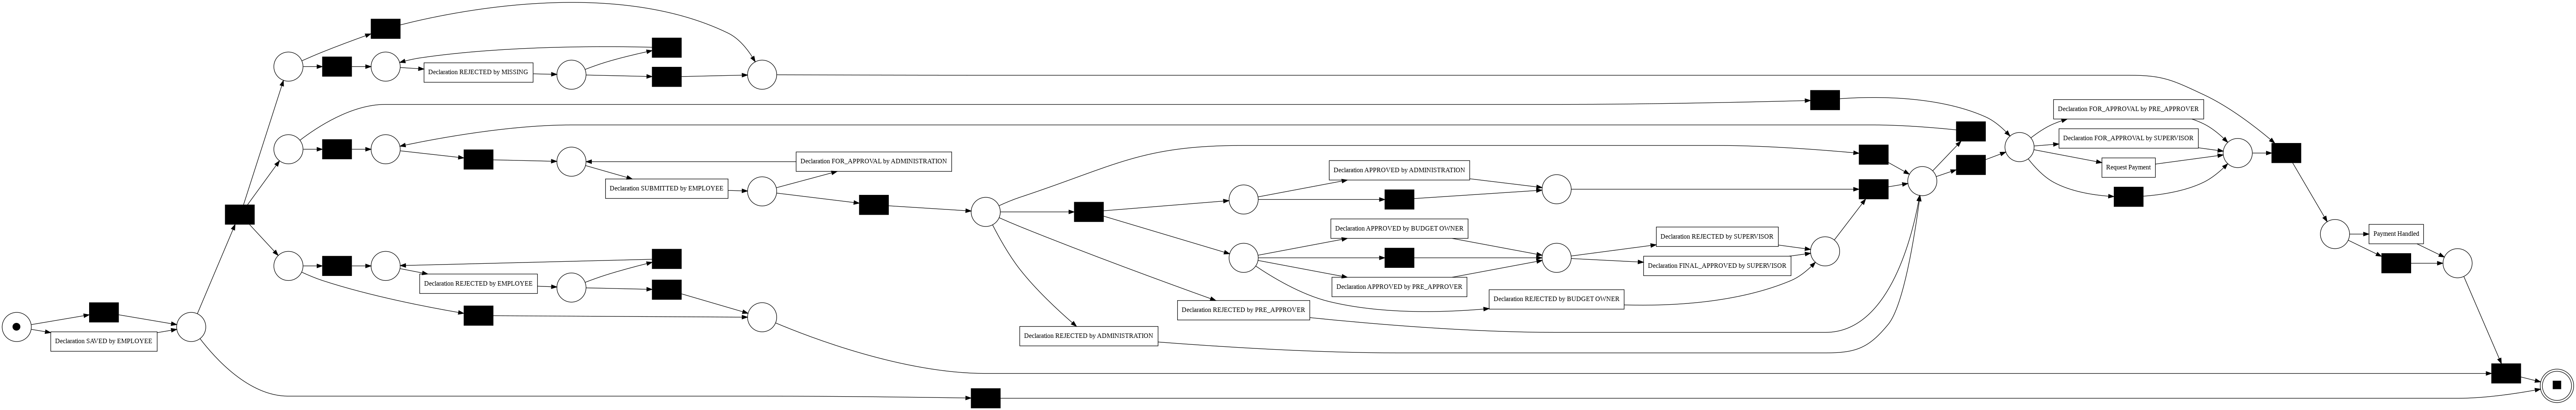

In [ ]:
process_tree = ProcessTreeFinder(df)
PTDraw(process_tree)

56437 17
[(0, 6), (1, 16), (2, 3, 11), (4, 15), (5, 15), (7,), (8,), (9, 12), (10, 13), (14,)] [7 6 9 5 8 0 4 3 2 1] [59, 1, 1, 1, 1, 293, 952, 2788, 85, 685]
(9, 12)


replaying log with TBR, completed traces ::   0%|          | 0/204 [00:00<?, ?it/s]

{'perc_fit_traces': 22.622450924337716, 'average_trace_fitness': 0.9352272596067215, 'log_fitness': 0.9355545005655792, 'percentage_of_fitting_traces': 22.622450924337716}


aligning log, completed variants ::   0%|          | 0/204 [00:00<?, ?it/s]

{'percFitTraces': 3.849818944158567, 'averageFitness': 0.6247063078586766, 'percentage_of_fitting_traces': 3.849818944158567, 'average_trace_fitness': 0.6247063078586766, 'log_fitness': 0.6183186514976264}
Iteration: 1 Fitness: 0.8747063078586766 Activity number 16 Events number 53828
(10, 13)


replaying log with TBR, completed traces ::   0%|          | 0/314 [00:00<?, ?it/s]

{'perc_fit_traces': 26.36146876490224, 'average_trace_fitness': 0.9361255839181758, 'log_fitness': 0.9364867085403252, 'percentage_of_fitting_traces': 26.36146876490224}


aligning log, completed variants ::   0%|          | 0/314 [00:00<?, ?it/s]

{'percFitTraces': 1.95517405817835, 'averageFitness': 0.6025539709588537, 'percentage_of_fitting_traces': 1.95517405817835, 'average_trace_fitness': 0.6025539709588537, 'log_fitness': 0.5918168765314002}
Iteration: 2 Fitness: 0.8525539709588537 Activity number 15 Events number 51430
(0, 6)


replaying log with TBR, completed traces ::   0%|          | 0/412 [00:00<?, ?it/s]

{'perc_fit_traces': 92.41484591164965, 'average_trace_fitness': 0.9937750172569001, 'log_fitness': 0.9935634839047045, 'percentage_of_fitting_traces': 92.41484591164965}


aligning log, completed variants ::   0%|          | 0/412 [00:00<?, ?it/s]

{'percFitTraces': 2.4806793244919376, 'averageFitness': 0.5977825930073026, 'percentage_of_fitting_traces': 2.4806793244919376, 'average_trace_fitness': 0.5977825930073026, 'log_fitness': 0.5866821119589808}
Iteration: 3 Fitness: 0.8477825930073026 Activity number 14 Events number 49223
(5, 15)


replaying log with TBR, completed traces ::   0%|          | 0/461 [00:00<?, ?it/s]

{'perc_fit_traces': 92.1909307875895, 'average_trace_fitness': 0.9934282313604604, 'log_fitness': 0.9933357104831118, 'percentage_of_fitting_traces': 92.1909307875895}


aligning log, completed variants ::   0%|          | 0/461 [00:00<?, ?it/s]

{'percFitTraces': 3.331742243436754, 'averageFitness': 0.5951812600022792, 'percentage_of_fitting_traces': 3.331742243436754, 'average_trace_fitness': 0.5951812600022792, 'log_fitness': 0.5845832521400365}
Iteration: 4 Fitness: 0.8451812600022792 Activity number 13 Events number 47236
(4, 15)


replaying log with TBR, completed traces ::   0%|          | 0/485 [00:00<?, ?it/s]

{'perc_fit_traces': 91.86968567880004, 'average_trace_fitness': 0.9930558724166868, 'log_fitness': 0.9930324590274711, 'percentage_of_fitting_traces': 91.86968567880004}


aligning log, completed variants ::   0%|          | 0/485 [00:00<?, ?it/s]

{'percFitTraces': 4.203687780643929, 'averageFitness': 0.5940967681724512, 'percentage_of_fitting_traces': 4.203687780643929, 'average_trace_fitness': 0.5940967681724512, 'log_fitness': 0.5842875941940171}
Iteration: 5 Fitness: 0.8440967681724512 Activity number 13 Events number 45410
(2, 3, 11)


replaying log with TBR, completed traces ::   0%|          | 0/537 [00:00<?, ?it/s]

{'perc_fit_traces': 92.32611611419813, 'average_trace_fitness': 0.985865476276088, 'log_fitness': 0.989492968727091, 'percentage_of_fitting_traces': 92.32611611419813}


aligning log, completed variants ::   0%|          | 0/537 [00:00<?, ?it/s]

{'percFitTraces': 0.8718145238551447, 'averageFitness': 0.21429952615883566, 'percentage_of_fitting_traces': 0.8718145238551447, 'average_trace_fitness': 0.21429952615883566, 'log_fitness': 0.21906603413433867}
Iteration: 6 Fitness: 0.46429952615883563 Activity number 11 Events number 38136
(1, 16)


replaying log with TBR, completed traces ::   0%|          | 0/557 [00:00<?, ?it/s]

{'perc_fit_traces': 89.375, 'average_trace_fitness': 0.9726626602564109, 'log_fitness': 0.9640661208095165, 'percentage_of_fitting_traces': 89.375}


aligning log, completed variants ::   0%|          | 0/557 [00:00<?, ?it/s]

{'percFitTraces': 0.0, 'averageFitness': 3.777472527472528e-05, 'percentage_of_fitting_traces': 0.0, 'average_trace_fitness': 3.777472527472528e-05, 'log_fitness': 6.0725864706623334e-05}
Iteration: 7 Fitness: 0.2500377747252747 Activity number 10 Events number 32890


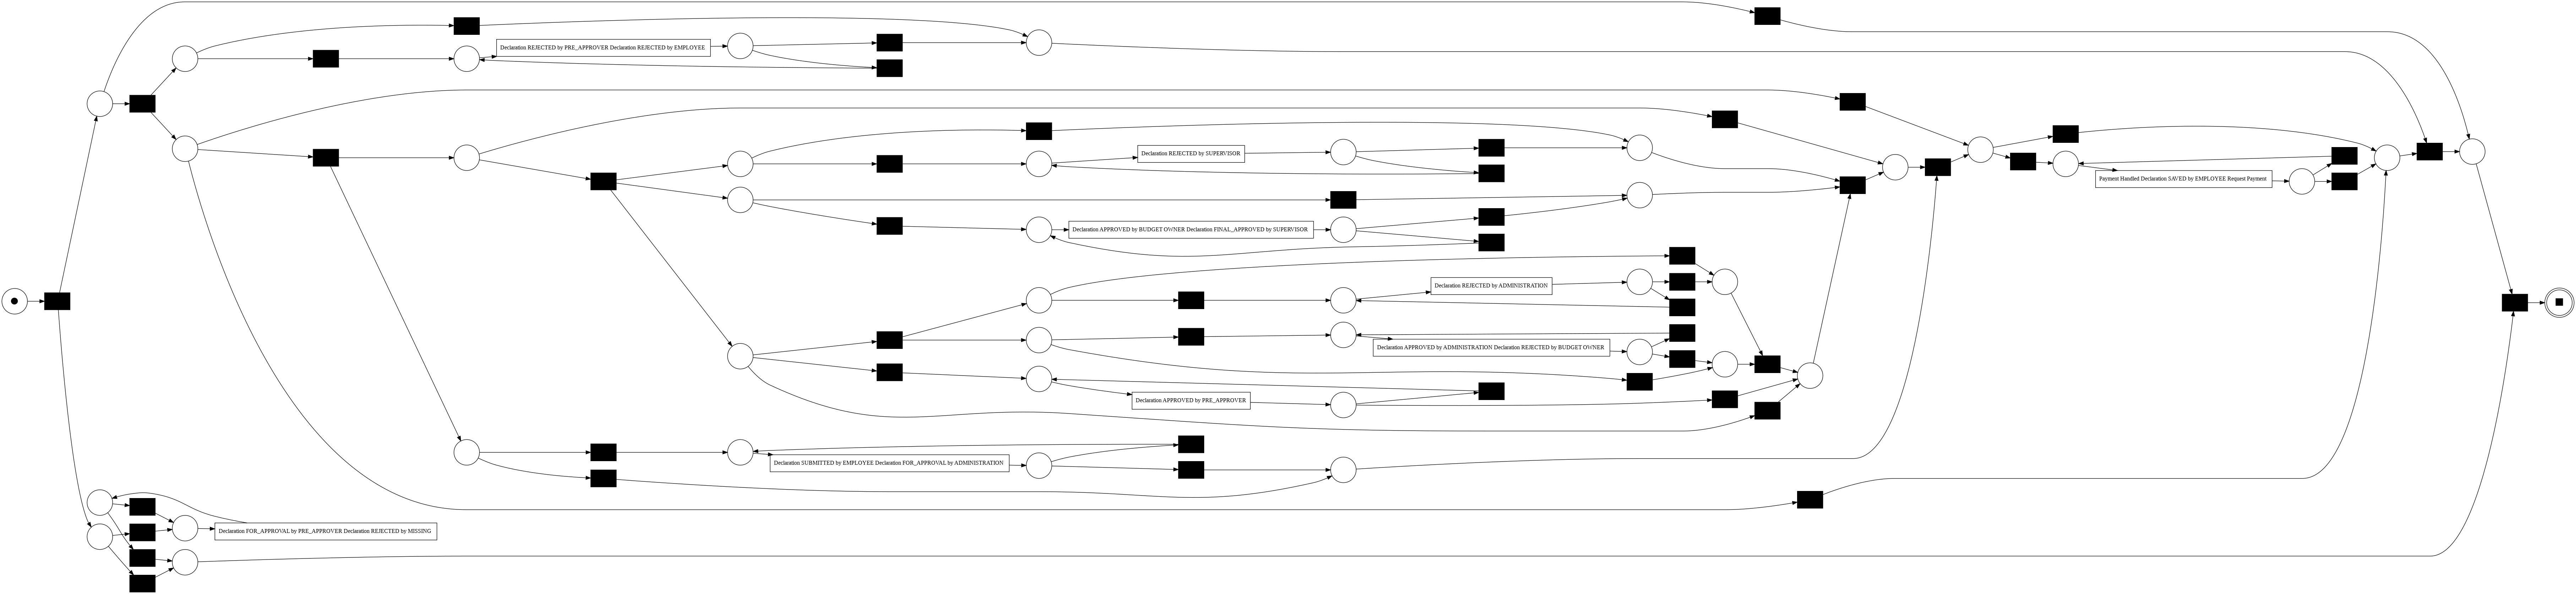

In [ ]:
new_df = Encoder(df, process_tree)
pt2 = ProcessTreeFinder(new_df)
PTDraw(pt2)

56437 17
[(0, 6), (1, 16), (2, 3, 11), (4, 15), (5, 15), (7,), (8,), (9, 12), (10, 13), (14,)] [7 6 9 5 8 0 4 3 2 1] [59, 1, 1, 1, 1, 293, 952, 2788, 85, 685]
(9, 12)


aligning log, completed variants ::   0%|          | 0/204 [00:00<?, ?it/s]

Iteration: 1 Fitness: 0.8747063078586766 Activity number 16 Events number 53828
53828 16
[(0, 7), (1, 13), (2, 15), (3, 4), (5, 14), (6, 14), (8,), (9,), (10, 12), (11,)] [9 7 6 3 8 0 5 4 2 1] [55, 0, 1, 112, 1, 1, 283, 903, 85, 9613]
(3, 4)


aligning log, completed variants ::   0%|          | 0/321 [00:00<?, ?it/s]

Iteration: 2 Fitness: 0.6786842819925898 Activity number 15 Events number 51408
51408 15
[(0, 5), (1, 11), (2, 14), (3, 12), (4, 12), (6,), (7,), (8, 10), (9, 13)] [8 6 5 7 0 4 3 2 1] [48, 0, 1, 1, 1, 276, 851, 83, 8395]
(9, 13)


aligning log, completed variants ::   0%|          | 0/472 [00:00<?, ?it/s]

Iteration: 3 Fitness: 0.4897899154516496 Activity number 14 Events number 42572
42572 11
[(0, 3), (1, 10), (2, 6, 8), (4,), (5,), (7, 9)] [4 3 5 1 2 0] [30, 61, 45, 228, 682, 109]
(7, 9)


aligning log, completed variants ::   0%|          | 0/567 [00:00<?, ?it/s]

Iteration: 4 Fitness: 0.48427132746457563 Activity number 10 Events number 36255
36255 10
[(0, 3), (1, 4, 9), (2, 7, 8), (5,), (6,)] [4 3 0 2 1] [24, 0, 22, 191, 588]
(0, 3)


aligning log, completed variants ::   0%|          | 0/557 [00:00<?, ?it/s]

Iteration: 5 Fitness: 0.47952118739671523 Activity number 9 Events number 31290
31290 9
[(0, 3, 8), (1, 6), (2, 4), (5, 7)] [3 2 1 0] [3, 28, 60, 252]
(5, 7)


aligning log, completed variants ::   0%|          | 0/440 [00:00<?, ?it/s]

Iteration: 6 Fitness: 0.454618004866177 Activity number 8 Events number 26850
26850 8
[(0, 7), (1, 3, 4, 6), (2,), (5,)] [2 3 0 1] [15, 0, 3941, 135]
(0, 7)


aligning log, completed variants ::   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 7 Fitness: 0.4528550726706805 Activity number 7 Events number 22910


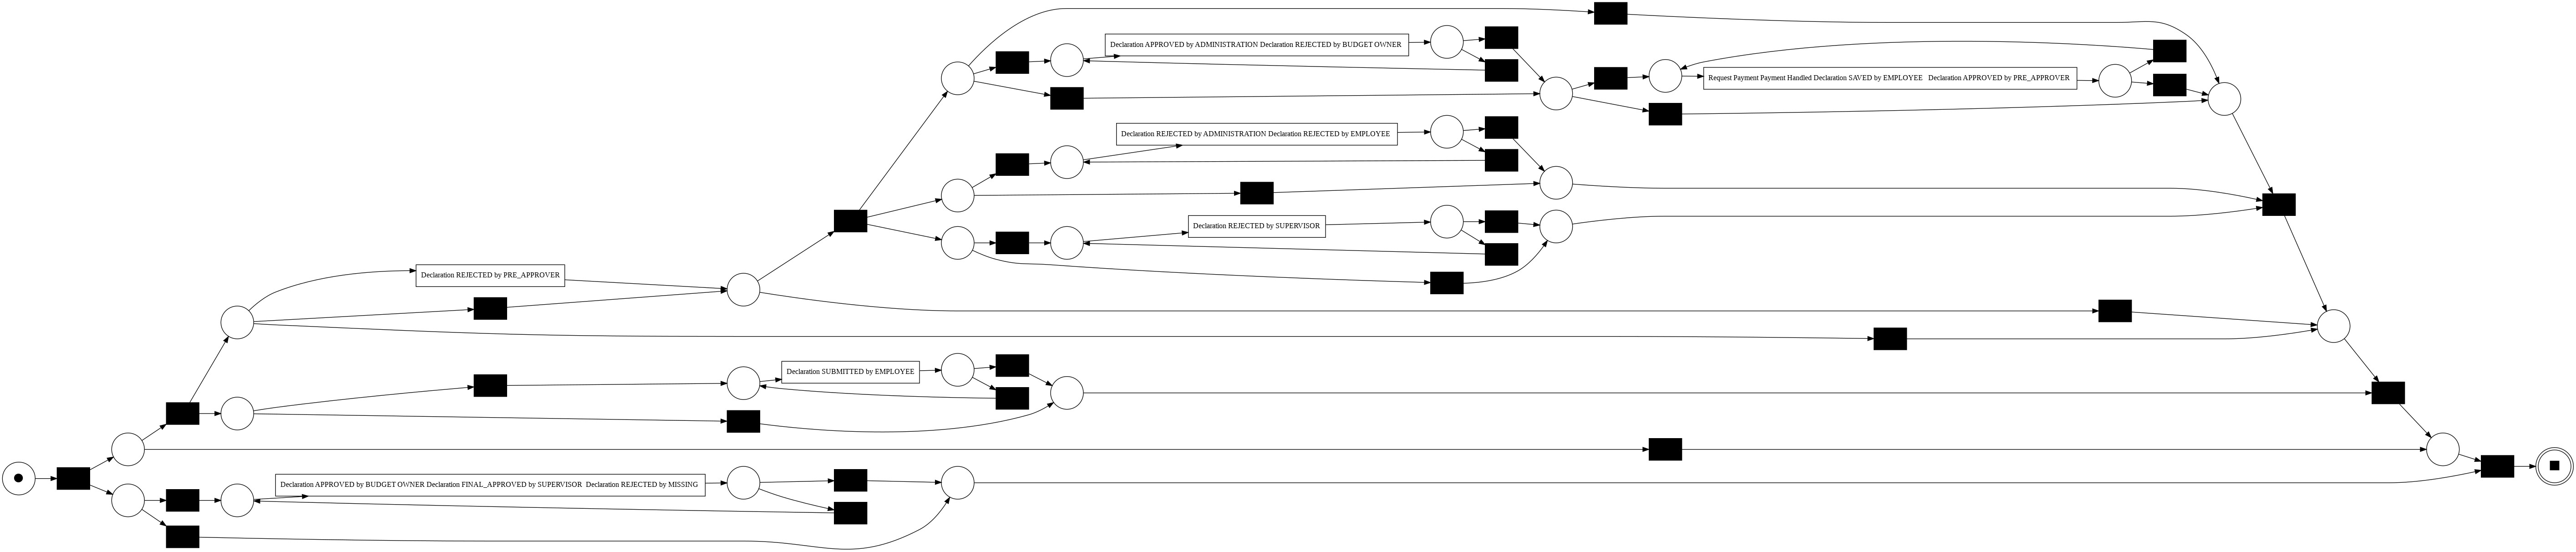

In [ ]:
new_df = Encoder2(df, process_tree, 1)
pt2 = ProcessTreeFinder(new_df)
PTDraw(pt2)